In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
np.random.seed(12)


Setup and Imports

In [ ]:
tickers = ["HDFCBANK.NS", "SILVERBEES.NS", "NIFTYBEES.NS"]
prices = yf.download(tickers, period="3y", auto_adjust=True)["Close"]

prices.dropna(inplace=True)
prices.head()


[*********************100%***********************]  3 of 3 completed


Ticker,HDFCBANK.NS,NIFTYBEES.NS,SILVERBEES.NS
Date,,,
2023-01-02,783.677917,199.339996,67.669998
2023-01-03,788.802307,199.679993,68.669998
2023-01-04,774.704163,197.669998,68.730003
2023-01-05,769.723999,197.070007,66.919998
2023-01-06,767.173889,195.720001,66.879997


Historica data,

In [ ]:
returns = prices.pct_change().dropna()

mu = returns.mean() * 252# Expected annual returns
Sigma = returns.cov() * 252# Annualized covariance

mu, Sigma

(Ticker
 HDFCBANK.NS      0.100405
 NIFTYBEES.NS     0.141829
 SILVERBEES.NS    0.434774
 dtype: float64,
 Ticker         HDFCBANK.NS  NIFTYBEES.NS  SILVERBEES.NS
 Ticker                                                 
 HDFCBANK.NS       0.033941      0.012338       0.002708
 NIFTYBEES.NS      0.012338      0.011523       0.002678
 SILVERBEES.NS     0.002708      0.002678       0.062617)

Annual Return and Variance

In [ ]:
n = len(mu)
w = cp.Variable(n)

objective = cp.Minimize(cp.quad_form(w, Sigma.values))
constraints = [
    cp.sum(w) == 1,
    w >= 0
]

problem = cp.Problem(objective, constraints)
problem.solve()

w_minvar = w.value
ret_minvar = mu.values @ w_minvar
vol_minvar = np.sqrt(w_minvar.T @ Sigma.values @ w_minvar)

pd.Series(w_minvar, index=tickers)


,0
HDFCBANK.NS,-7.664700e-23
SILVERBEES.NS,8.714155e-01
NIFTYBEES.NS,1.285845e-01


Objective adn constraints.

In [ ]:
target_returns = np.linspace(ret_minvar, mu.max(), 40)

frontier_returns = []
frontier_volatility = []
frontier_weights = []

for R_target in target_returns:
    w = cp.Variable(n)

    objective = cp.Minimize(cp.quad_form(w, Sigma.values))
    constraints = [
        cp.sum(w) == 1,
        mu.values @ w >= R_target,
        w >= 0
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is not None:
        frontier_weights.append(w.value)
        frontier_returns.append(mu.values @ w.value)
        frontier_volatility.append(
            np.sqrt(w.value.T @ Sigma.values @ w.value)
        )


Naive Portfolio,Equal Weight Portfolio

In [ ]:
w_equal = np.ones(n) / n
ret_equal = mu.values @ w_equal
vol_equal = np.sqrt(w_equal.T @ Sigma.values @ w_equal)


Naive Portfolio,Random

In [ ]:
num_random = 5000
rand_returns = []
rand_vols = []

for _ in range(num_random):
    w = np.random.random(n)
    w /= np.sum(w)

    rand_returns.append(mu.values @ w)
    rand_vols.append(np.sqrt(w.T @ Sigma.values @ w))


Plots ANd Comparison

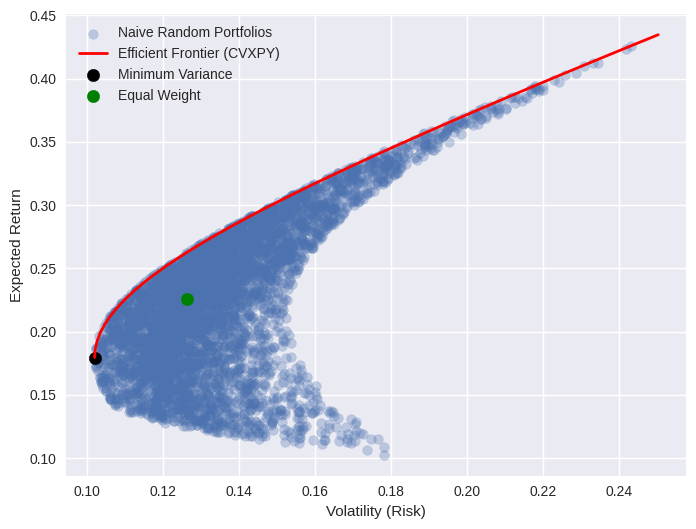

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(rand_vols, rand_returns,alpha=0.3, label="Naive Random Portfolios")
plt.plot(frontier_volatility, frontier_returns,color="red", linewidth=2, label="Efficient Frontier (CVXPY)")
plt.scatter(vol_minvar, ret_minvar, color="black", s=80, label="Minimum Variance")
plt.scatter(vol_equal,ret_equal,color="green",s=80, label="Equal Weight")

plt.xlabel("Volatility Risk")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.show()


Solver Output,Optimal Weights

In [ ]:
frontier_df = pd.DataFrame(
    frontier_weights,
    columns=tickers
)

frontier_df.head()


,HDFCBANK.NS,SILVERBEES.NS,NIFTYBEES.NS
0,-7.664700e-23,0.871416,0.128584
1,6.326069e-24,0.849072,0.150928
2,4.093968e-24,0.826728,0.173272
3,3.096544e-24,0.804384,0.195616
4,5.173204e-24,0.782040,0.217960


The near-zero negative weights are numerical artifacts from the convex solver.
Under long-only constraints, the optimizer assigns zero allocation to HDFCBANK,
indicating it does not lie on the efficient frontier for the given data,

In [ ]:
# Least Volatility Portfolio (Single optimization)

w_min = cp.Variable(n)

objective = cp.Minimize(cp.quad_form(w_min, Sigma.values))
constraints = [
    cp.sum(w_min) == 1,
    w_min >= 0
]

prob = cp.Problem(objective, constraints)
prob.solve()

w_minvar = w_min.value
ret_minvar = mu.values @ w_minvar
vol_minvar = np.sqrt(w_minvar.T @ Sigma.values @ w_minvar)

print(pd.Series(w_minvar, index=tickers))
print("Return:", ret_minvar)
print("Volatility:", vol_minvar)


HDFCBANK.NS     -7.664700e-23
SILVERBEES.NS    8.714155e-01
NIFTYBEES.NS     1.285845e-01
dtype: float64
Return: 0.1794971526286484
Volatility: 0.1019100387814826


Previous weeks least variance portfolio.

In [ ]:
# One Markowitz portfolio from the Efficient Frontier
k = 2
# 3rd portfolio on the frontier

w_mark = frontier_weights[k]
ret_mark = mu.values @ w_mark
vol_mark = np.sqrt(w_mark.T @ Sigma.values @ w_mark)

print("MARKOWITZ PORTFOLIO (Row 3)")
print(pd.Series(w_mark, index=tickers))
print("Return:", ret_mark)
print("Volatility:", vol_mark)


MARKOWITZ PORTFOLIO (Row 3)
HDFCBANK.NS      4.093968e-24
SILVERBEES.NS    8.267276e-01
NIFTYBEES.NS     1.732724e-01
dtype: float64
Return: 0.19258825877101843
Volatility: 0.10258175766461988


Lets compare the minimum varaince with the a bit of higher volatility.

In [ ]:
comparison = pd.DataFrame({
    "Least Volatility": [ret_minvar, vol_minvar],
    "Markowitz (Row 3)": [ret_mark, vol_mark]
}, index=["Expected Return", "Volatility"])

comparison


,Least Volatility,Markowitz (Row 3)
Expected Return,0.179497,0.192588
Volatility,0.101910,0.102582
